In [53]:
import pandas as pd
import pickle
# import numpy as np # linear algebra
# # import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from datetime import datetime
import regex as re
import pickle
import gensim
import datapreproc
from gensim import models
from gensim import corpora
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
import gensim
import numpy as np
import nltk
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/djtom/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/djtom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/djtom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/djtom/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Loading the data.

In [2]:
ec=pickle.load(open("../data/Sentiment_Market_Pharma/earnings_call_top10_ph.pickle", "rb"))
ec=ec.reset_index()

preprocessing data consists of using different huggingface transformers for ner to remove names and then using lowercase bert to remove punctuation.

In [3]:
ec=datapreproc.process_ec(ec)
txt=ec.cleanedec.tolist()

In [50]:
# simplify Penn tags to n (NOUN), v (VERB), a (ADJECTIVE) or r (ADVERB)
def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'

In [11]:
# toks = gensim.utils.simple_preprocess(str(txt), deacc=True)

In [12]:
def preprocess(text):
    stop_words = stopwords.words('english')
    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer()
    # return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]
    return [tok for tok in toks if tok not in stop_words]

In [9]:
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = stopwords.words('english')

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

def tokenize(words, modulation):
    tokens = re.split(r'\W+', words)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if re.search('[a-zA-Z]', lowers):
            if modulation==1:
                w = porter.stem(lowers)
            if modulation==2:
                w = lmtzr.lemmatize(lowers)
            if modulation==0:
                w = lowers
            if w not in stop_words:
              stems.append(w)
    return stems

In [10]:
# reproducibility
seed = 42
# python RNG
import random
random.seed(seed)
# numpy RNG
import numpy as np
np.random.seed(seed)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

In [13]:
#remember that modulation fixes the pre-processing
#let's experiment with 0 (nothing) vs. 1 (stemming) vs. 2 (lemmatizing)
texts=[tokenize(document,2) for document in txt]

In [14]:
#making bigrams and trigrams with collocations 
bigram = gensim.models.Phrases(texts, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[texts], threshold=1)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in texts]
texts_trigrams = [trigram_mod[doc] for doc in texts]

In [25]:
topicnumber=10
id2word = corpora.Dictionary(texts_trigrams)
id2word.filter_extremes(no_below = 110, no_above=0.4)
corpus = [id2word.doc2bow(text) for text in texts_trigrams]

lda_model = gensim.models.ldamodel.LdaModel(
          corpus=corpus, id2word=id2word, num_topics=topicnumber, random_state=100, 
          update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
)

In [26]:
id2word,corpus

(<gensim.corpora.dictionary.Dictionary at 0x7fbaa3f0b190>,
 [[(0, 1),
   (1, 2),
   (2, 1),
   (3, 2),
   (4, 1),
   (5, 1),
   (6, 1),
   (7, 1),
   (8, 1),
   (9, 1),
   (10, 1),
   (11, 1),
   (12, 7),
   (13, 1),
   (14, 1),
   (15, 1),
   (16, 2),
   (17, 4),
   (18, 3),
   (19, 1),
   (20, 1),
   (21, 1),
   (22, 1),
   (23, 1),
   (24, 1),
   (25, 1),
   (26, 4),
   (27, 1),
   (28, 4),
   (29, 1),
   (30, 1),
   (31, 1),
   (32, 1),
   (33, 2),
   (34, 2),
   (35, 1),
   (36, 1),
   (37, 1),
   (38, 1),
   (39, 3),
   (40, 2),
   (41, 3),
   (42, 2),
   (43, 1),
   (44, 2),
   (45, 2),
   (46, 2),
   (47, 1),
   (48, 1),
   (49, 1),
   (50, 1),
   (51, 3),
   (52, 1),
   (53, 1),
   (54, 1),
   (55, 1),
   (56, 7),
   (57, 1),
   (58, 2),
   (59, 2),
   (60, 2),
   (61, 1),
   (62, 2),
   (63, 1),
   (64, 1),
   (65, 2),
   (66, 1),
   (67, 2),
   (68, 4),
   (69, 1),
   (70, 1),
   (71, 2),
   (72, 1),
   (73, 1),
   (74, 1),
   (75, 2),
   (76, 1),
   (77, 1),
   (78, 1),
   

In [27]:
lda_model.print_topics(topicnumber)

[(0,
  '0.013*"pfizer" + 0.013*"lilly" + 0.012*"john" + 0.012*"animal_health" + 0.008*"biosimilars" + 0.008*"volume_growth" + 0.006*"fx" + 0.006*"exchange" + 0.006*"ph" + 0.006*"phase_ii"'),
 (1,
  '0.040*"weve" + 0.023*"youre" + 0.022*"weve_seen" + 0.021*"dont" + 0.015*"im" + 0.014*"youve" + 0.013*"ill" + 0.013*"whats" + 0.010*"hospital" + 0.009*"dont_think"'),
 (2,
  '0.016*"second_line" + 0.015*"overall_survival" + 0.011*"indiscernible" + 0.011*"astrazeneca" + 0.009*"breast_cancer" + 0.008*"survival" + 0.008*"testing" + 0.008*"endpoint" + 0.007*"non_small" + 0.007*"immuno_oncology"'),
 (3,
  '0.016*"please_go" + 0.012*"operating_income" + 0.011*"constant_currency" + 0.009*"division" + 0.009*"indiscernible" + 0.008*"pharma" + 0.008*"percentage_point" + 0.007*"ph" + 0.007*"insulin" + 0.006*"operating_profit"'),
 (4,
  '0.019*"lung" + 0.015*"tumor" + 0.013*"non_small" + 0.013*"cell_lung" + 0.012*"animal_health" + 0.010*"small_cell" + 0.009*"chemotherapy" + 0.009*"regimen" + 0.008*"mela

In [28]:
def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) 
              for t in range(ntopics) 
              for w,p in model.get_topic_terms(t, topn=1)]
              
    terms = [modeldict[w] for t in range(ntopics)
             for w, p in model.get_topic_terms(t, topn=3)]
    id_terms = [w for t in range(ntopics)
             for w, p in model.get_topic_terms(t, topn=3)]
    fig,ax=plt.subplots(figsize=(12, 6))
    print(model.get_topics()[:, id_terms].shape)
    ax.imshow(model.get_topics()[:, id_terms])  # plot the numpy matrix
    ax.set_xticks(np.arange(30))  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

(10, 30)


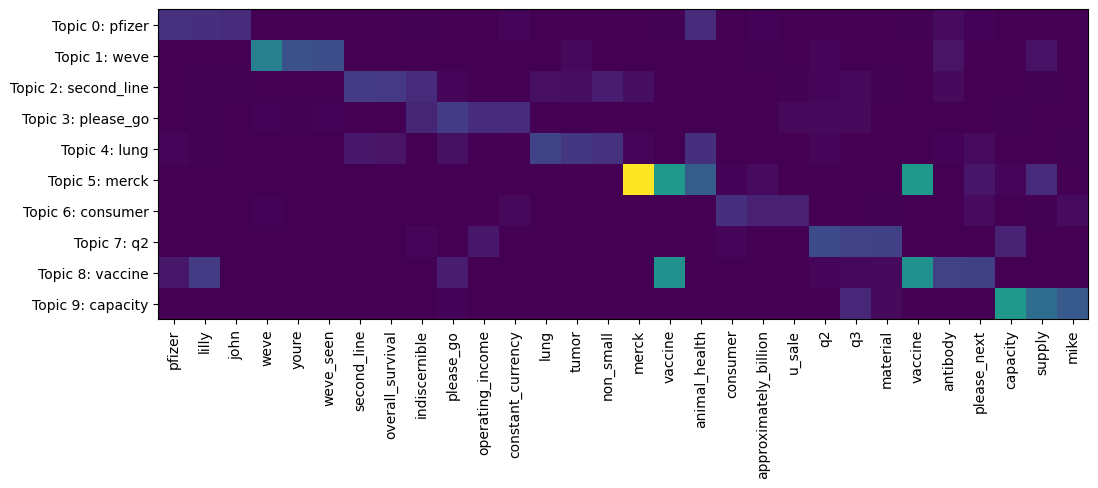

In [29]:
viz_model(lda_model, id2word)

## Now we will attempt to seed the LDA model with our priors sourced from S and P reports.

In [32]:
#manual way of switching model is to comment out this line
frequency = defaultdict(int)

for text in texts_bigrams:
    for token in text:
        frequency[token] += 1

_texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts_bigrams
]

#pprint(texts)

dictionary = corpora.Dictionary(_texts)
print(dictionary)

dictionary.filter_extremes(no_below = 110, no_above=0.4)
# we are getting rid of things like "said" with the no_above 
# threshold (depending on stemming more will be thrown out)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in _texts]

Dictionary<121715 unique tokens: ['13th_year', 'absolute_number', 'absolute_reduction', 'accelerate_growth', 'accelerated']...>
Dictionary<731 unique tokens: ['advantage', 'also_expect', 'animal_health', 'appreciate', 'approximately_billion']...>


In [33]:
#this cell creates a very low prior for all terms not in the dictionary (priors) and a very high prior for terms found
#in the dictionary
#watch out that you need to pass a dictionary that is pre-processed the same way you are pre-processing the text

def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=0.0001) # create a (ntopics, nterms) matrix and fill with low number
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 500  # put a large number in there
    return eta

In [57]:
#load the dictionary that you want to load - the number is the topic number you want to attribute the priors to
#you can attribute terms to more than one topic


#generate the eta vector
eta = create_eta(apriori_original, dictionary, 6)

In [58]:
topicnumber=6

#alpha default is ’symmetric’: Uses a fixed symmetric prior of 1.0 / num_topics. In our case that is 0.1.

lda=models.LdaModel(corpus, id2word=dictionary, num_topics=topicnumber, 
                    random_state=42, eta=eta, alpha='symmetric')

lda.print_topics(topicnumber)

[(0,
  '0.007*"merck" + 0.006*"thats" + 0.006*"vaccine" + 0.005*"customer" + 0.004*"lung" + 0.004*"come_line" + 0.004*"animal_health" + 0.004*"application" + 0.004*"overall_survival" + 0.004*"pfizer"'),
 (1,
  '0.022*"net_income" + 0.008*"vaccine" + 0.005*"pfizer" + 0.005*"lung" + 0.005*"q2" + 0.005*"merck" + 0.005*"come_line" + 0.004*"please_next" + 0.004*"indiscernible" + 0.004*"thats"'),
 (2,
  '0.007*"thats" + 0.006*"vaccine" + 0.006*"consumer" + 0.006*"lilly" + 0.005*"year_date" + 0.005*"merck" + 0.005*"please_next" + 0.005*"currency" + 0.004*"animal_health" + 0.004*"indiscernible"'),
 (3,
  '0.020*"operating_income" + 0.019*"operating_profit" + 0.006*"thats" + 0.005*"animal_health" + 0.005*"come_line" + 0.005*"insulin" + 0.005*"lilly" + 0.004*"q2" + 0.004*"year_date" + 0.004*"indiscernible"'),
 (4,
  '0.008*"vaccine" + 0.008*"thats" + 0.006*"pfizer" + 0.006*"animal_health" + 0.005*"merck" + 0.004*"pharma" + 0.004*"come_line" + 0.004*"currency" + 0.004*"q1" + 0.004*"phase_ii"'),
 

(6, 18)


ValueError: The number of FixedLocator locations (30), usually from a call to set_ticks, does not match the number of labels (18).

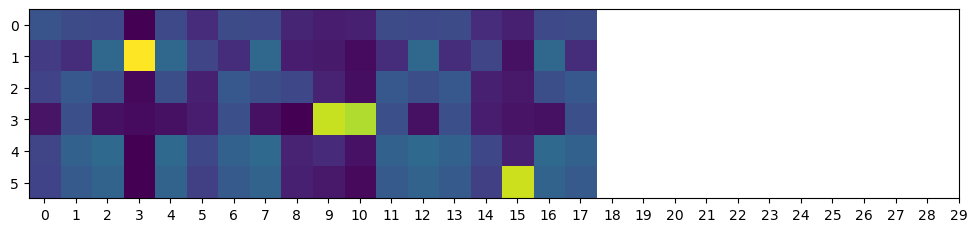

In [59]:
viz_model(lda, dictionary)

In [35]:
#emulating the sp500 quant report on ideal topics and bidirectional tags to extract from earnings calls
t1_revenue=['sales', 'revenue', 'top line', 'top bottom line', 'net revenue', 'organic revenue growth', 'organic sales growth', 'operational sales']
t2_earnings=['eps', 'earnings', 'earnings per share',
'net income', 'bottom line', 'top bottom line']
t3_profitability=['margin', 'gross margin', 'operating margin', 'return invested capital', 'return capital']
t4_operatingincome=['ebit', 'operating income', 'operating profit', 'operating earning']
t5_cashflow=['cash flow', 'operating cash flow', 'cash flow operations',
'free cash flow']
t6_shareholderreturn=['buyback', 'dividends', 'dividend per share', 'share repurchase', 'repurchased million shares']
uniontopics=t1_revenue+t2_earnings+t3_profitability+t4_operatingincome+t5_cashflow+t6_shareholderreturn

In [36]:
for word in uniontopics[0:3]:
    mask=ec.cleanedec.str.contains(word)
    result=ec[mask].content
    print(f"{word} exists in the following rows:\n{result.count()}\n")

sales exists in the following rows:
514

revenue exists in the following rows:
457

top line exists in the following rows:
321



Okay so a casual investigation of the data reveals that there are sufficient mentions of these terms within the earnings calls to justify a topic modeling based on this approach. Let's give this a try!

In [37]:
#struggling with getting trigrams into topic modeling topics
#should I get the lists into the 
alltopic_format=[]
for word in uniontopics:
    alltopic_format.append('_'.join(word.split(' ')))

In [38]:
t1_revenue_f=[]
t2_earnings_f=[]
t3_profitability_f=[]
t4_operatingincome_f=[]
t5_cashflow_f=[]
t6_shareholderreturn_f=[]


In [39]:
for word in t1_revenue:
    t1_revenue_f.append('_'.join(word.split(' ')))
for word in t2_earnings:
    t2_earnings_f.append('_'.join(word.split(' ')))
for word in t3_profitability:
    t3_profitability_f.append('_'.join(word.split(' ')))
for word in t4_operatingincome:
    t4_operatingincome_f.append('_'.join(word.split(' ')))
for word in t5_cashflow:
    t5_cashflow_f.append('_'.join(word.split(' ')))
for word in t6_shareholderreturn:
    t6_shareholderreturn_f.append('_'.join(word.split(' ')))

In [40]:
trigram_bigram_root=[]
for word in ['_'.join(x.split('_')[0:2]) for x in alltopic_format if x.count('_') > 1 ]:
    trigram_bigram_root.append(word)
    

In [41]:
bigrams_pure=[]
for word in ['_'.join(x.split('_')[0:2]) for x in alltopic_format if x.count('_') == 1 ]:
    bigrams_pure.append(word)
    

In [42]:
unigrams_pure=[]
for word in [x for x in alltopic_format if x.count('_') <1 ]:
    unigrams_pure.append(word)
unigrams_pure=list(set(unigrams_pure))

In [44]:
bigram = gensim.models.Phrases(texts, min_count=1, threshold=5) # higher threshold fewer phrases.

In [45]:
frozen_bigram = bigram.freeze()  # freeze bigrams' scores for compactness/efficiency
for bigramword in trigram_bigram_root:
    frozen_bigram.phrasegrams[bigramword] = float('inf')
for unigramword in unigrams_pure:
    frozen_bigram.phrasegrams[unigramword] = float('inf')
for bigramword in bigrams_pure:
    frozen_bigram.phrasegrams[bigramword] = float('inf')

In [47]:
trigram = gensim.models.Phrases(frozen_bigram[texts], threshold=1) 
trifreeze=trigram.freeze()
for word in alltopic_format:
    trifreeze.phrasegrams[word]=float('Inf')

# trigram_mod = gensim.models.phrases.Phraser(trifreeze)
words_trigram = [trifreeze[doc] for doc in texts]
dictionarytrigram = gensim.corpora.Dictionary(words_trigram)
len(dictionarytrigram)

55752

In [48]:
apriori_original = dict()
for a in t1_revenue_f:
    apriori_original[a]=0

for b in t2_earnings_f:

    apriori_original[b]=1

for c in t3_profitability_f:
    
    apriori_original[c]=2

for d in t4_operatingincome_f:

    apriori_original[d]=3
for e in t5_cashflow_f:

    apriori_original[e]=4

for f in t6_shareholderreturn_f:
    apriori_original[f]=5

# for b in 

# t1_revenue_f=[]
# t2_earnings_f=[]
# t3_profitability_f=[]
# t4_operatingincome_f=[]
# t5_cashflow_f=[]
# t6_shareholderreturn_f=[]
#generate the eta vector
# eta = create_eta(apriori_original, dictionary, 10)

In [49]:
apriori_original

{'sales': 0,
 'revenue': 0,
 'top_line': 0,
 'top_bottom_line': 1,
 'net_revenue': 0,
 'organic_revenue_growth': 0,
 'organic_sales_growth': 0,
 'operational_sales': 0,
 'eps': 1,
 'earnings': 1,
 'earnings_per_share': 1,
 'net_income': 1,
 'bottom_line': 1,
 'margin': 2,
 'gross_margin': 2,
 'operating_margin': 2,
 'return_invested_capital': 2,
 'return_capital': 2,
 'ebit': 3,
 'operating_income': 3,
 'operating_profit': 3,
 'operating_earning': 3,
 'cash_flow': 4,
 'operating_cash_flow': 4,
 'cash_flow_operations': 4,
 'free_cash_flow': 4,
 'buyback': 5,
 'dividends': 5,
 'dividend_per_share': 5,
 'share_repurchase': 5,
 'repurchased_million_shares': 5}

In [31]:
# trigram = gensim.models.Phrases(frozen_phrases[corp], threshold=10) 

In [32]:
# trifreeze=trigram.freeze()
# trifreeze.phrasegrams['top_bottom_line']=float('Inf')
# trifreeze.phrasegrams['organic_revenue_growth']=float('Inf')
# trifreeze.phrasegrams['organic_sales_growth']=float('Inf')
# trifreeze.phrasegrams['earnings_per_share']=float('Inf')
# trifreeze.phrasegrams['return_invested_capital']=float('Inf')


In [33]:
# trigram_mod = gensim.models.phrases.Phraser(trifreeze)
# words_trigram = [trifreeze[doc] for doc in corp]

In [44]:
# import pickle

# filehandler = open("../data/ldamodel.pkl","wb")
# pickle.dump(ldamodel_1,filehandler)
# filehandler.close()


In [34]:

filehandler=open("../data/ldamodel.pkl","rb")
ldamodel_1=pickle.load(filehandler)
filehandler.close()

In [35]:
topicallocation=[]
for doc in words_trigram:
    topicallocation.append(ldamodel_1.get_document_topics(bow=dictionarytrigram.doc2bow(doc)))

In [36]:
for i,t in enumerate(topicallocation):
    for topic, prob in t:
        topic='topic'+str(topic)
        ec10.loc[ec10.index[i],topic]=prob

In [44]:
ec=ec.fillna(0)

In [60]:
#dictionary based topic modeling
positive_words=[ 'increase', 'increased', 'increases', 'increasing', 'increasingly', 'expand', 'expanded', 'expanding', 'expands', 'expansion', 'expansions', 'grow', 'grows', 'grew', 'growth', 'growths', 'improve', 'improved', 'improves', 'improvement', 'improvements', 'strong', 'stronger', 'strongest', 'strongly' ]
negative_words=['decline', 'declined', 'declines', 'declining', 'deteriorate', 'deteriorates', 'deteriorated', 'deteriorating', 'compress', 'compressed', 'compresses', 'compressing', 'compressible', 'compression', 'reduce', 'reduces', 'reduced', 'reducing', 'reduction', 'reductions', 'weak', 'weaker', 'weakest', 'weaken', 'weakens', 'weakened', 'weakening', 'weakness', 'weaknesses']
guidance_words=['full year outlook', 'full year expect', 'guidance', 'outlook', 'forecast', 'expect', 'expects', 'expected', 'expecting', 'expectation', 'expectations']

In [61]:
t1_revenue_f
t2_earnings_f
t3_profitability_f
t4_operatingincome_f
t5_cashflow_f
t6_shareholderreturn_f

['buyback',
 'dividends',
 'dividend_per_share',
 'share_repurchase',
 'repurchased_million_shares']

In [63]:
#cosine similarity based on the topic modeling
from sklearn.metrics.pairwise import cosine_similarity
ec

index symbol  quarter  year        date  \
0        0    PFE        4  2007  2008-01-24   
1        0    PFE        3  2007  2007-10-18   
2        0    PFE        2  2007  2007-07-18   
3        0    PFE        4  2008  2009-01-28   
4        0    PFE        1  2008  2008-04-17   
..     ...    ...      ...   ...         ...   
510      0    MRK        4  2020  2021-02-04   
511      0    MRK        1  2021  2021-04-29   
512      0    MRK        2  2021  2021-07-29   
513      0    MRK        3  2021  2021-10-28   
514      0    MRK        4  2021  2022-02-03   

                                               content  \
0    Operator: Amal Naj, Head of Development. Pleas...   
1    Operator: Mr. Amal Naj, Senior VicePresident o...   
2    Operator: Amal Naj, Head of Investor Relations...   
3    Operator: Good morning ladies and gentlemen an...   
4    Operator: Now we have Amal Naj, Head of Invest...   
..                                                 ...   
510  Operator: Good morning. My name is Lara, and I...   
511  Operator: Good morning. My name is Lara, and I...   
512  Operator: Good morning. My name is Mary Serran...   
513  Operator: Good morning. My name is Grace Lakra...   
514  Operator: Good morning. My name is Grace Lakra...   

                                             cleanedec  
0     amal naj, head of development. please begin t...  
1     mr. amal naj, senior vicepresident of investo...  
2     al naj, head of investor relations, you may b...  
3      ladies and gentlemen and welcome to quarter ...  
4     now we have amal naj, head of investor develo...  
..                                                 ...  
510   . my name is lara, and i will be your confere...  
511   . my name is lara, and i will be your confere...  
512   . my name is mary serran (ph), and i will be ...  
513   . my name is grace lakra and i'll be your con...  
514   . my name is grace lakra, and ill be your con...  

[515 rows x 7 columns]

In [64]:
nltk.sent_tokenize(ec['cleanedec'].iloc[0])

[' amal naj, head of development.',
 'please begin the call.',
 'amal naj: head of investor development.',
 'and thank you for joining us on this call to review our fourth quarter 2007 performance.',
 "i am here with jeff kindler, chairman and ceo; frank d'amelio, chief financial officer, and other members of our senior management.",
 "the financial chart that will be presented on this call can be viewed on our homepage at www.pfizer.com in the investor presentations tab by clicking on the link quarterly corporate performance - fourth quarter 2007. we will end our conference call at 1 o'clock sharp, and as we would like you to... as we would like to hear from as many as you and in this time we would appreciate if you would limit yourself to just one part question.",
 'time permitting we will come back to you for any follow-ups.',
 'before we start, i would like to remind you that our discussions during this conference call will include forward-looking statements.',
 'actual results cou

In [65]:
def topiccount(doc):
    c1,c2,c3,c4,c5,c6,i=0,0,0,0,0,0,0

    for sent in nltk.sent_tokenize(doc):
        if any(word in sent for word in t1_revenue):
            c1+=1
        if any(word in sent for word in t2_earnings):
            c2+=1
        if any(word in sent for word in t3_profitability):
            c3+=1
        if any(word in sent for word in t4_operatingincome):
            c4+=1
        if any(word in sent for word in t5_cashflow):
            c5+=1
        if any(word in sent for word in t6_shareholderreturn):
            c6+=1
        i+=1
    return c1/i,c2/i,c3/i,c4/i,c5/i,c6/i


In [66]:
def directionalitycount(doc):
    c1,c2,c3,c4,c5,c6,i=0,0,0,0,0,0,0

    for sent in nltk.sent_tokenize(doc):
        if any(word in sent for word in t1_revenue) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c1+=1
        if any(word in sent for word in t1_revenue) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c1-=1
        if any(word in sent for word in t2_earnings) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c2+=1
        if any(word in sent for word in t2_earnings) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c2-=1
        if any(word in sent for word in t3_profitability) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c3+=1
        if any(word in sent for word in t3_profitability) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c3-=1
        if any(word in sent for word in t4_operatingincome) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c4+=1
        if any(word in sent for word in t4_operatingincome) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c4-=1
        if any(word in sent for word in t5_cashflow) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c5+=1
        if any(word in sent for word in t5_cashflow) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c5-=1
        if any(word in sent for word in t6_shareholderreturn) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c6+=1
        if any(word in sent for word in t6_shareholderreturn) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c6-=1
        i+=1
    return c1/i,c2/i,c3/i,c4/i,c5/i,c6/i


In [67]:
def guidancecount(doc):
    c1,c2,c3,c4,c5,c6,i=0,0,0,0,0,0,0

    for sent in nltk.sent_tokenize(doc):
        if any(word in sent for word in t1_revenue) and any(word in sent for word in positive_words):
            c1+=1
        if any(word in sent for word in t1_revenue) and any(word in sent for word in negative_words):
            c1-=1
        if any(word in sent for word in t2_earnings) and any(word in sent for word in positive_words):
            c2+=1
        if any(word in sent for word in t2_earnings) and any(word in sent for word in negative_words):
            c2-=1
        if any(word in sent for word in t3_profitability) and any(word in sent for word in positive_words):
            c3+=1
        if any(word in sent for word in t3_profitability) and any(word in sent for word in negative_words):
            c3-=1
        if any(word in sent for word in t4_operatingincome) and any(word in sent for word in positive_words):
            c4+=1
        if any(word in sent for word in t4_operatingincome) and any(word in sent for word in negative_words):
            c4-=1
        if any(word in sent for word in t5_cashflow) and any(word in sent for word in positive_words):
            c5+=1
        if any(word in sent for word in t5_cashflow) and any(word in sent for word in negative_words):
            c5-=1
        if any(word in sent for word in t6_shareholderreturn) and any(word in sent for word in positive_words):
            c6+=1
        if any(word in sent for word in t6_shareholderreturn) and any(word in sent for word in negative_words):
            c6-=1
        i+=1
    return c1/i,c2/i,c3/i,c4/i,c5/i,c6/i


In [81]:
topicdictcount=ec.copy()

In [82]:
topicdictcount['result']=topicdictcount.cleanedec.apply(topiccount)
topicdictcount[['t1','t2','t3','t4','t5','t6']]=topicdictcount['result'].to_list()

In [89]:
topicdictcount

index symbol  quarter  year        date  \
0        0    PFE        4  2007  2008-01-24   
1        0    PFE        3  2007  2007-10-18   
2        0    PFE        2  2007  2007-07-18   
3        0    PFE        4  2008  2009-01-28   
4        0    PFE        1  2008  2008-04-17   
..     ...    ...      ...   ...         ...   
510      0    MRK        4  2020  2021-02-04   
511      0    MRK        1  2021  2021-04-29   
512      0    MRK        2  2021  2021-07-29   
513      0    MRK        3  2021  2021-10-28   
514      0    MRK        4  2021  2022-02-03   

                                               content  \
0    Operator: Amal Naj, Head of Development. Pleas...   
1    Operator: Mr. Amal Naj, Senior VicePresident o...   
2    Operator: Amal Naj, Head of Investor Relations...   
3    Operator: Good morning ladies and gentlemen an...   
4    Operator: Now we have Amal Naj, Head of Invest...   
..                                                 ...   
510  Operator: Good morning. My name is Lara, and I...   
511  Operator: Good morning. My name is Lara, and I...   
512  Operator: Good morning. My name is Mary Serran...   
513  Operator: Good morning. My name is Grace Lakra...   
514  Operator: Good morning. My name is Grace Lakra...   

                                             cleanedec  \
0     amal naj, head of development. please begin t...   
1     mr. amal naj, senior vicepresident of investo...   
2     al naj, head of investor relations, you may b...   
3      ladies and gentlemen and welcome to quarter ...   
4     now we have amal naj, head of investor develo...   
..                                                 ...   
510   . my name is lara, and i will be your confere...   
511   . my name is lara, and i will be your confere...   
512   . my name is mary serran (ph), and i will be ...   
513   . my name is grace lakra and i'll be your con...   
514   . my name is grace lakra, and ill be your con...   

                                                result        t1        t2  \
0    (0.09943714821763602, 0.03377110694183865, 0.0...  0.099437  0.033771   
1    (0.08668076109936575, 0.046511627906976744, 0....  0.086681  0.046512   
2    (0.06172839506172839, 0.009876543209876543, 0....  0.061728  0.009877   
3    (0.0708215297450425, 0.04815864022662889, 0.00...  0.070822  0.048159   
4    (0.12108559498956159, 0.04801670146137787, 0.0...  0.121086  0.048017   
..                                                 ...       ...       ...   
510  (0.010845986984815618, 0.010845986984815618, 0...  0.010846  0.010846   
511  (0.05, 0.026470588235294117, 0.020588235294117...  0.050000  0.026471   
512  (0.034334763948497854, 0.006437768240343348, 0...  0.034335  0.006438   
513  (0.0437375745526839, 0.009940357852882704, 0.0...  0.043738  0.009940   
514  (0.053452115812917596, 0.026726057906458798, 0...  0.053452  0.026726   

     ...       t3d  t4d       t5d  t6d      t1dg      t2dg      t3dg  t4dg  \
0    ...  0.000000  0.0  0.001876  0.0  0.020638  0.005629  0.001876   0.0   
1    ...  0.000000  0.0  0.000000  0.0 -0.002114 -0.010571  0.000000   0.0   
2    ...  0.000000  0.0  0.000000  0.0 -0.007407  0.002469  0.000000   0.0   
3    ...  0.000000  0.0  0.002833  0.0  0.022663  0.011331  0.000000   0.0   
4    ...  0.000000  0.0  0.000000  0.0  0.027140  0.002088  0.004175   0.0   
..   ...       ...  ...       ...  ...       ...       ...       ...   ...   
510  ...  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.006508   0.0   
511  ...  0.005882  0.0  0.000000  0.0  0.014706  0.011765  0.005882   0.0   
512  ...  0.012876  0.0  0.000000  0.0  0.023605  0.000000  0.021459   0.0   
513  ...  0.000000  0.0  0.000000  0.0  0.025845  0.003976  0.003976   0.0   
514  ...  0.002227  0.0  0.002227  0.0  0.037862  0.011136  0.002227   0.0   

         t5dg      t6dg  
0    0.001876  0.000000  
1    0.000000  0.002114  
2    0.000000  0.000000  
3    0.005666  0.000000  
4    0.002088  0.000000  
..  

In [83]:
topicdictcount[['t1d','t2d','t3d','t4d','t5d','t6d']]=topicdictcount.cleanedec.apply(directionalitycount).to_list()

In [84]:
topicdictcount[['t1dg','t2dg','t3dg','t4dg','t5dg','t6dg']]=topicdictcount.cleanedec.apply(guidancecount).to_list()

(<Axes: >, <Axes: >, <Axes: >)

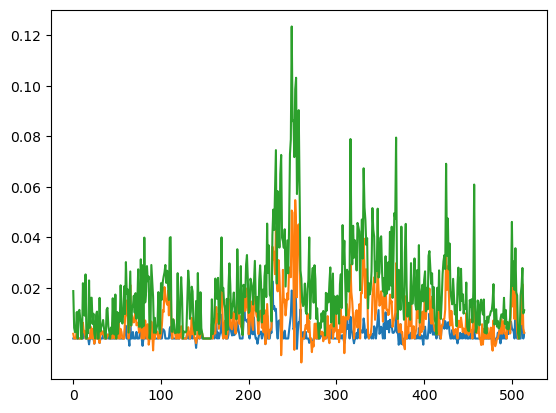

In [91]:
topicdictcount['t3d'].plot(),topicdictcount['t3dg'].plot(),topicdictcount['t3'].plot()

<Axes: >

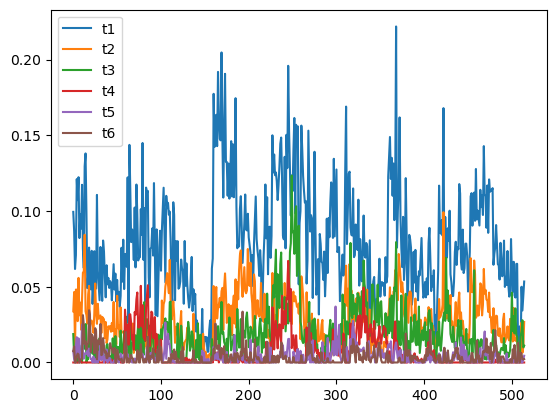

In [92]:
topicdictcount[['t1','t2','t3','t4','t5','t6']].plot()

In [85]:
topicdictcount[['t1d','t2d','t3d','t4d','t5d','t6d']].describe()

t1d         t2d         t3d         t4d         t5d         t6d
count  515.000000  515.000000  515.000000  515.000000  515.000000  515.000000
mean     0.005454    0.002481    0.001759    0.001029    0.000273    0.000123
std      0.006485    0.003672    0.003245    0.002858    0.000901    0.000612
min     -0.009901   -0.004769   -0.004739   -0.003597   -0.002160   -0.002421
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
50%      0.004098    0.001733    0.000000    0.000000    0.000000    0.000000
75%      0.008402    0.004094    0.002571    0.000000    0.000000    0.000000
max      0.040909    0.038168    0.022727    0.020833    0.006818    0.004706

In [95]:
topicdictcount.drop(columns=['result'],inplace=True)

In [98]:
# topicdictcount.drop(columns=['index'],inplace=True)
topicdictcount.to_csv("../data/ectopicdictcount.csv")

In [93]:
stock_prices_ec = stock_prices.dropna(subset=['content'])


NameError: name 'stock_prices' is not defined

In [ ]:
stock_prices_ec = stock_prices_ec.dropna(subset=['eps_mean','eps_mean_report'])
stock_prices_ec = stock_prices_ec.reset_index()
stock_prices_ec

## Adding a topic modeling based on perplexity and human interpretability scores

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [64]:
text_series=pd.Series(corp).apply(lambda x : ' '.join(x))

In [65]:
len(dictionary)

29068

In [82]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim_models

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Preprocess the text
stop_words = set(stopwords.words('english'))
preprocessed_text = text_series.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])

# Create a dictionary and document-term matrix
dictionary = Dictionary(preprocessed_text)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_text]

# Train the LDA model
num_topics = 4
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)


[nltk_data] Downloading package stopwords to /home/djtom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/djtom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
def topics(lda_model, vectorizer, n_top_words):

    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda_model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [84]:
# Visualize the topic model using PyLDAvis
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [69]:
# gensim implementation 
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import multiprocessing

In [70]:
text_series

0      operator head development please begin call he...
1      operator mr al senior vicepresident investor d...
2      operator head investor relations may begin tha...
3      operator good morning ladies gentlemen welcome...
4      operator head investor development may begin g...
                             ...                        
510    operator good morning name conference operator...
511    operator good morning name conference operator...
512    operator good morning name ph conference opera...
513    operator good morning name conference operator...
514    operator good morning name conference operator...
Length: 515, dtype: object

In [71]:
gensim_corpus = [doc.split() for doc in text_series.to_list()]
# gensim_corpus[:1]
# create dictionary from corpus
dictionary = Dictionary(gensim_corpus)
# dictionary.filter_extremes(no_below=100, no_above=0.1)
dictionary

In [73]:
ldacorpus = [dictionary.doc2bow(doc) for doc in gensim_corpus]

In [74]:
dictionary[100] # 100 unique id or index given to word liquid in the dictionary

'associates'

In [75]:
# tfidf model
tfidfmodel = TfidfModel(ldacorpus)
tfidfmodel

In [76]:
# transform to the format required by gensim lda function
tfidfmodel_corpus = tfidfmodel[ldacorpus]
tfidfmodel_corpus

In [77]:
number_topics = 20

# find chunksize to make about 200 updates
lda_gensim = LdaMulticore(tfidfmodel_corpus, 
                          id2word=dictionary,
                          num_topics=number_topics,
                          workers=min(4, multiprocessing.cpu_count()-1), # number of cores
                          passes=10, # training passes
                          chunksize=200, # no. of documents in each training chuck
                         )
lda_gensim

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [78]:
# print top 5 most relevant words for each topic
lda_gensim.print_topics(num_words=5)

[(0,
  '0.003*"wachob" + 0.002*"dennis" + 0.002*"avinash" + 0.002*"loughran" + 0.002*"janice"'),
 (1,
  '0.000*"cel" + 0.000*"orva" + 0.000*"unintelligible" + 0.000*"ide" + 0.000*"reblozyl"'),
 (2,
  '0.003*"rinvoq" + 0.002*"skyrizi" + 0.002*"imfinzi" + 0.002*"tmb" + 0.001*"allergan"'),
 (3,
  '0.000*"olysio" + 0.000*"ag" + 0.000*"cindy" + 0.000*"adnexus" + 0.000*"beovu"'),
 (4,
  '0.000*"mondher" + 0.000*"azd" + 0.000*"saxa" + 0.000*"durva" + 0.000*"externalization"'),
 (5,
  '0.003*"hern" + 0.002*"kevin" + 0.002*"trulicity" + 0.002*"dan" + 0.002*"christi"'),
 (6,
  '0.001*"judy" + 0.001*"donanemab" + 0.001*"trailblazer" + 0.001*"lewent" + 0.000*"tau"'),
 (7,
  '0.000*"raymund" + 0.000*"breu" + 0.000*"christian" + 0.000*"lotrel" + 0.000*"zelnorm"'),
 (8,
  '0.000*"vasella" + 0.000*"hearn" + 0.000*"daniel" + 0.000*"tekturna" + 0.000*"jake"'),
 (9,
  '0.001*"fetch" + 0.000*"rebein" + 0.000*"sorenson" + 0.000*"durel" + 0.000*"avinas"'),
 (10,
  '0.000*"michel" + 0.000*"covid" + 0.000*"jo

In [79]:
from gensim.models import CoherenceModel

In [80]:
# initialize list to save coherence values and lda model
coherence_values = []
lda_models = []

# for each value of n
for n in range(5, 21):

    # train the lda model with n topics
    model = LdaMulticore(tfidfmodel_corpus, 
                         id2word=dictionary,
                         num_topics=n,
                         workers=min(8, multiprocessing.cpu_count()-1), # number of cores
                         passes=10, # training passes
                         chunksize=200, # no. of documents in each training chuck
                         )
    # add the model to the corresponding initialized list
    lda_models.append(model)
    
    # create coherence model with the above trained lda model
    coherencemodel = CoherenceModel(model=model, texts=gensim_corpus, dictionary=dictionary, coherence='c_v')
    
    # add the value for n and the coherence to the corresponding initialized list
    coherence_val = coherencemodel.get_coherence()
    print(n, coherence_val)
    coherence_values.append( (n, coherence_val) )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

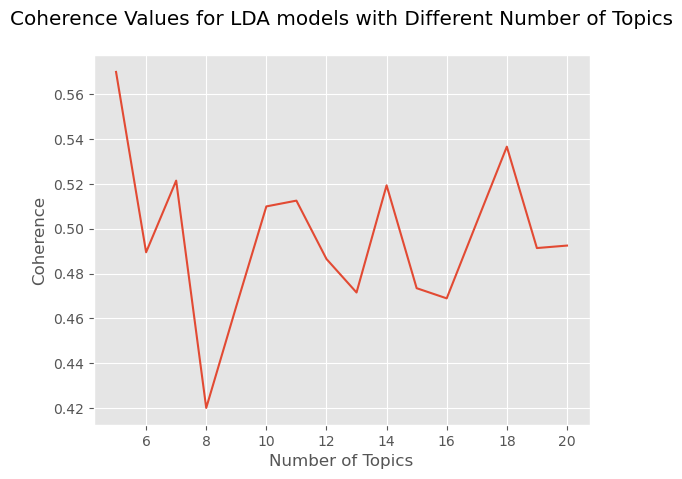

In [81]:
plt.style.use('ggplot')
plt.plot(*zip(*coherence_values))
plt.title('Coherence Values for LDA models with Different Number of Topics\n')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.show()